In [ ]:
!pip install datasets

In [56]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

device = "cpu"

In [57]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name)     # loading the pre-trained model

**Load Dataset**

In [58]:
from datasets import load_dataset

ds = load_dataset("albertvillanova/medmnist-v2", "breastmnist")    # download & load the dataset

In [59]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['malignant', 'normal, benign'], id=None)

**Data Preprocessing**

In [60]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")

  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]

  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [61]:
import matplotlib.pyplot as plt
def show_image(dataset, split, index):
    data = dataset[split][index]
    if "image" in data:  # Original dataset
        image = data["image"]
        label = data["label"]

        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Class {label}", fontsize=8)
        plt.show()
    else:  # Transformed dataset
        image_tensor = data['pixel_values']
        label = data['labels']

        # Convert the tensor to a NumPy array and display the image
        image_array = image_tensor.numpy()  # Convert the torch tensor to a NumPy array
        plt.figure(figsize=(1, 1))
        plt.imshow(image_array.transpose(1, 2, 0))  # Matplotlib expects the channel dimension last
        plt.title(f"Class {label}", fontsize=8)
        plt.axis('off')  # Hide the axis
        plt.show()

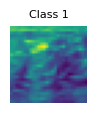

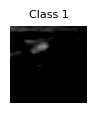

In [62]:
idx = 2
show_image(ds, "train", idx)
show_image(dataset, "train", idx)

In [63]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
1


In [64]:
labels = ds["train"].features["label"].names

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [65]:
!pip install evaluate

In [66]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  precision_score = precision.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  recall_score = recall.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score, **precision_score, **recall_score}

In [67]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
!pip install accelerate -U

In [69]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.25.0')

In [70]:
# Restart the kernel
# import os
# os._exit(00)

In [71]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-food", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=10,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


In [72]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [73]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=180, training_loss=0.10214951833089193, metrics={'train_runtime': 235.7744, 'train_samples_per_second': 23.158, 'train_steps_per_second': 0.763, 'total_flos': 4.231062632956723e+17, 'train_loss': 0.10214951833089193, 'epoch': 10.0})

In [74]:
trainer.evaluate(dataset["test"])

{'eval_loss': 0.537784993648529,
 'eval_accuracy': 0.9038461538461539,
 'eval_f1': 0.8768874625138106,
 'eval_precision': 0.9304347826086956,
 'eval_recall': 0.9385964912280702,
 'eval_runtime': 3.2502,
 'eval_samples_per_second': 47.997,
 'eval_steps_per_second': 6.153,
 'epoch': 10.0}

**Evaluation with Confusion Matrix**

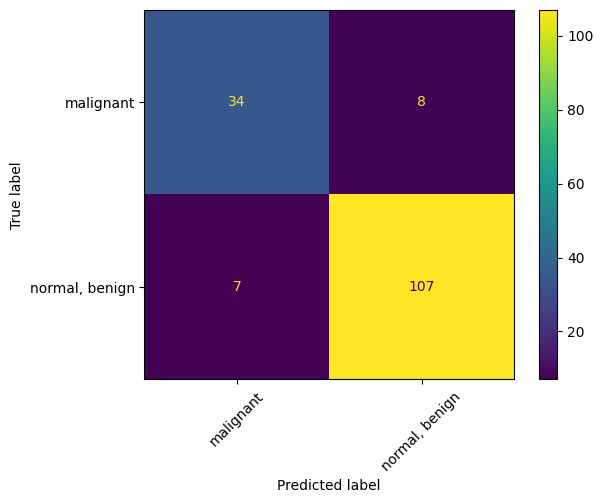

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(dataset["test"])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = dataset["train"].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

**Generate Precision, Recall, F1 Score, Support**

In [76]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([0.82926829, 0.93043478]),
 array([0.80952381, 0.93859649]),
 array([0.81927711, 0.93449782]),
 array([ 42, 114]))